<a href="https://colab.research.google.com/github/teja-1403/Capstone/blob/main/CCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cervical Cancer Detection**

In [ ]:
# Install necessary libraries
!pip install opencv-python tensorflow keras scikit-image scikit-learn seaborn matplotlib

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import slic
from skimage.color import label2rgb
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# SLIC Segmentation
def apply_slic(image_path, num_segments=100):

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # SLIC
    segments = slic(img, n_segments=num_segments, compactness=10, start_label=1)

    superpixel_image = label2rgb(segments, img, kind='avg')
    # uint8
    superpixel_image = (superpixel_image * 255).astype(np.uint8)
    return superpixel_image

In [ ]:
def preprocess_dataset(input_dir, output_dir, num_segments=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        save_path = os.path.join(output_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                processed_img = apply_slic(img_path, num_segments)
                save_file = os.path.join(save_path, img_file)
                cv2.imwrite(save_file, processed_img)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
train_dir = "/content/drive/MyDrive/CCD/SingleCellPAP/Training"
test_dir = "/content/drive/MyDrive/CCD/SingleCellPAP/Test"

processed_train_dir = "/content/drive/MyDrive/CCD/processed_Training"
processed_test_dir = "/content/drive/MyDrive/CCD/processed_Test"

preprocess_dataset(train_dir, processed_train_dir, num_segments=100)
preprocess_dataset(test_dir, processed_test_dir, num_segments=100)

In [ ]:
# Canny Edge Detection
def apply_edge_detection_on_superpixel(superpixel_img):
    gray = cv2.cvtColor(superpixel_img, cv2.COLOR_BGR2GRAY)

    # Canny edge
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)

    superpixel_with_edges = superpixel_img.copy()
    superpixel_with_edges[edges > 0] = [255, 0, 0]  # edges in red

    return superpixel_with_edges

In [ ]:
def process_superpixels_with_edges(input_dir, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        save_path = os.path.join(output_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                superpixel_img = cv2.imread(img_path)

                processed_img = apply_edge_detection_on_superpixel(superpixel_img)

                save_file = os.path.join(save_path, img_file)
                cv2.imwrite(save_file, processed_img)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
processed_train_dir = "/content/drive/MyDrive/CCD/processed_Training"
processed_test_dir = "/content/drive/MyDrive/CCD/processed_Test"

processed_with_edges_train_dir = "/content/drive/MyDrive/CCD/processed_with_edges_Training"
processed_with_edges_test_dir = "/content/drive/MyDrive/CCD/processed_with_edges_Test"

process_superpixels_with_edges(processed_train_dir, processed_with_edges_train_dir)
process_superpixels_with_edges(processed_test_dir, processed_with_edges_test_dir)

In [ ]:
train_dir = "/content/drive/MyDrive/CCD/processed_with_edges_Training"
test_dir = "/content/drive/MyDrive/CCD/processed_with_edges_Test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3559 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [ ]:
# ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 164s 920ms/step - accuracy: 0.5974 - loss: 9.1939 - val_accuracy: 0.2000 - val_loss: 9.3912
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 642ms/step - accuracy: 0.8906 - loss: 7.5819 - val_accuracy: 0.2120 - val_loss: 9.3881
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 644ms/step - accuracy: 0.8974 - loss: 6.7202 - val_accuracy: 0.2000 - val_loss: 11.1094
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 650ms/step - accuracy: 0.9177 - loss: 5.8210 - val_accuracy: 0.2000 - val_loss: 9.0310
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 632ms/step - accuracy: 0.9469 - loss: 4.9907 - val_accuracy: 0.2260 - val_loss: 6.7045
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 78s 654ms/step - accuracy: 0.9410 - loss: 4.2939 - val_accuracy: 0.2880 - val_loss: 5.6081
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 642ms/step - accuracy: 0.9436 - loss: 3.6750 - val_accuracy: 0.3000 - val_loss: 5.0040
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 644ms/step - accuracy: 0.9489 - loss:

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9217 - loss: 2.1239
Test Accuracy: 92.00000166893005 %


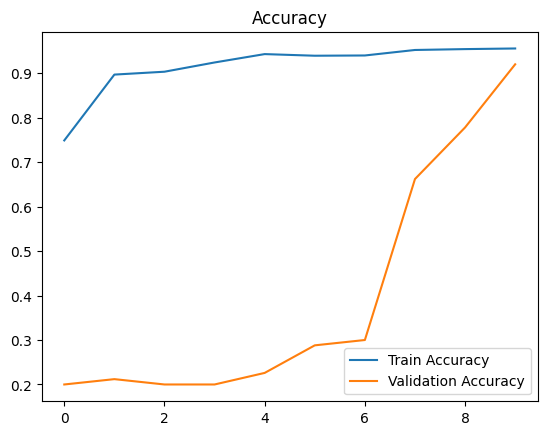

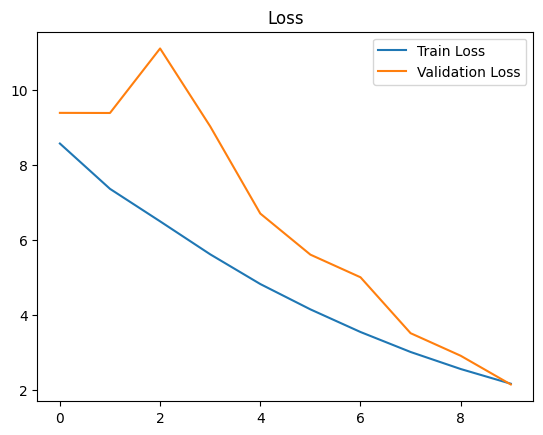

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step


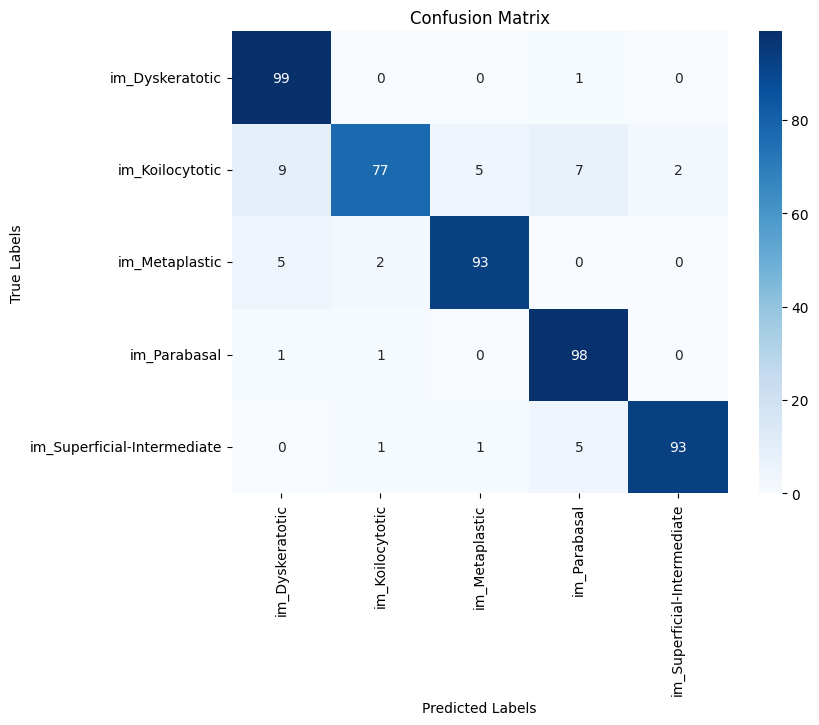

In [ ]:
# Confusion matrix
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.87      0.99      0.93       100
            im_Koilocytotic       0.95      0.77      0.85       100
             im_Metaplastic       0.94      0.93      0.93       100
               im_Parabasal       0.88      0.98      0.93       100
im_Superficial-Intermediate       0.98      0.93      0.95       100

                   accuracy                           0.92       500
                  macro avg       0.92      0.92      0.92       500
               weighted avg       0.92      0.92      0.92       500



In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC: {:.4f}".format(roc_auc))

Macro-Averaged ROC-AUC: 0.9915


<ipython-input-41-96ad4249f651>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


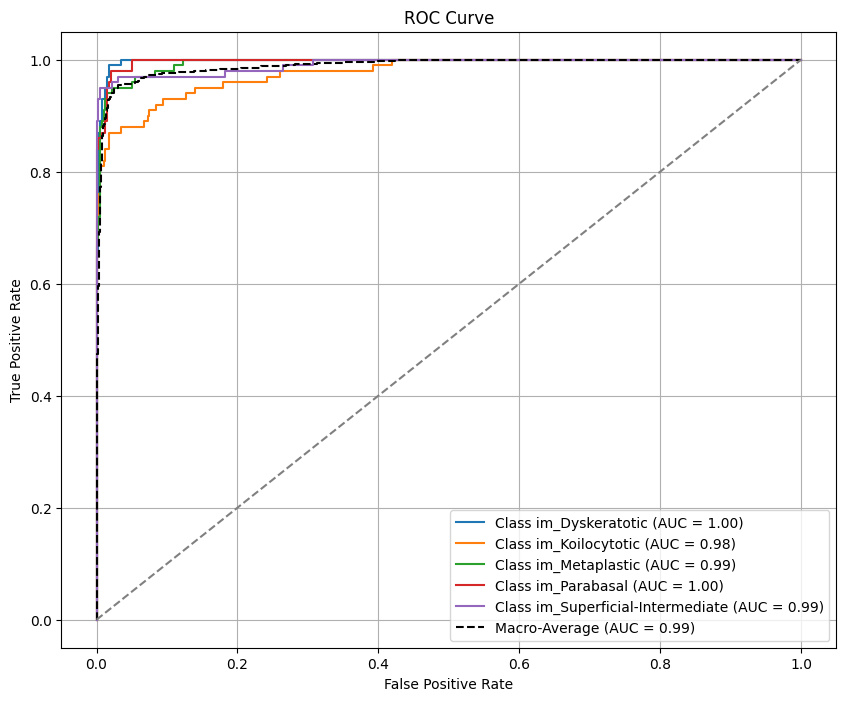

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# VGG16
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the Model
vgghist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 171s 978ms/step - accuracy: 0.8718 - loss: 8.5445 - val_accuracy: 0.8160 - val_loss: 10.3738
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 708ms/step - accuracy: 0.9273 - loss: 5.5204 - val_accuracy: 0.8740 - val_loss: 5.3784
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 694ms/step - accuracy: 0.9280 - loss: 4.8327 - val_accuracy: 0.7980 - val_loss: 13.6558
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 753ms/step - accuracy: 0.9382 - loss: 4.0313 - val_accuracy: 0.9180 - val_loss: 3.7391
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 740ms/step - accuracy: 0.9586 - loss: 3.4405 - val_accuracy: 0.9280 - val_loss: 3.2429
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 136s 702ms/step - accuracy: 0.9426 - loss: 3.1704 - val_accuracy: 0.8960 - val_loss: 3.0022
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 146s 728ms/step - accuracy: 0.9513 - loss: 2.7470 - val_accuracy: 0.8800 - val_loss: 2.9273
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 725ms/step - accuracy: 0.9545 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9228 - loss: 2.0622
Test Accuracy: 89.3999993801117 %


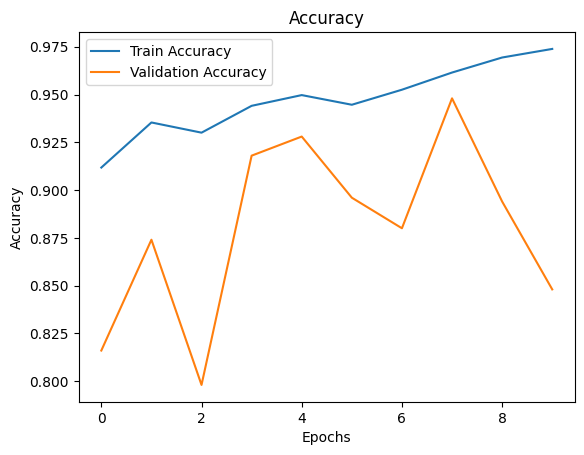

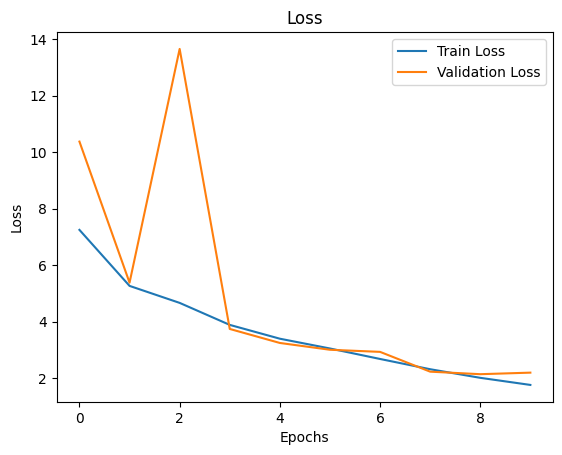

In [ ]:
# Plot accuracy
plt.plot(vgghist.history['accuracy'], label='Train Accuracy')
plt.plot(vgghist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(vgghist.history['loss'], label='Train Loss')
plt.plot(vgghist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 937ms/step


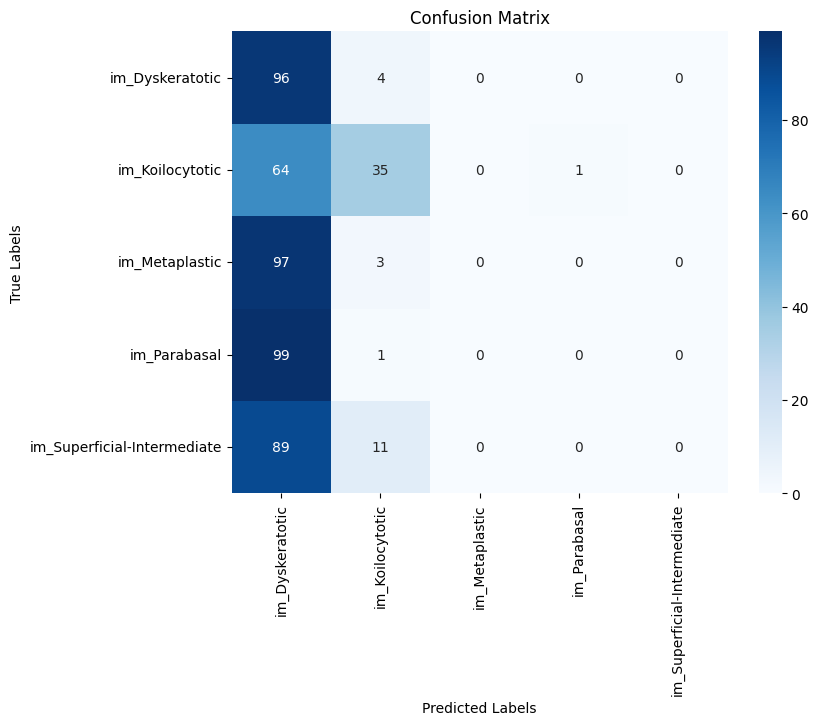

In [ ]:
# Confusion matrix
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.22      0.96      0.35       100
            im_Koilocytotic       0.65      0.35      0.45       100
             im_Metaplastic       0.00      0.00      0.00       100
               im_Parabasal       0.00      0.00      0.00       100
im_Superficial-Intermediate       0.00      0.00      0.00       100

                   accuracy                           0.26       500
                  macro avg       0.17      0.26      0.16       500
               weighted avg       0.17      0.26      0.16       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC: {:.4f}".format(roc_auc))

Macro-Averaged ROC-AUC: 0.5782


<ipython-input-51-96ad4249f651>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


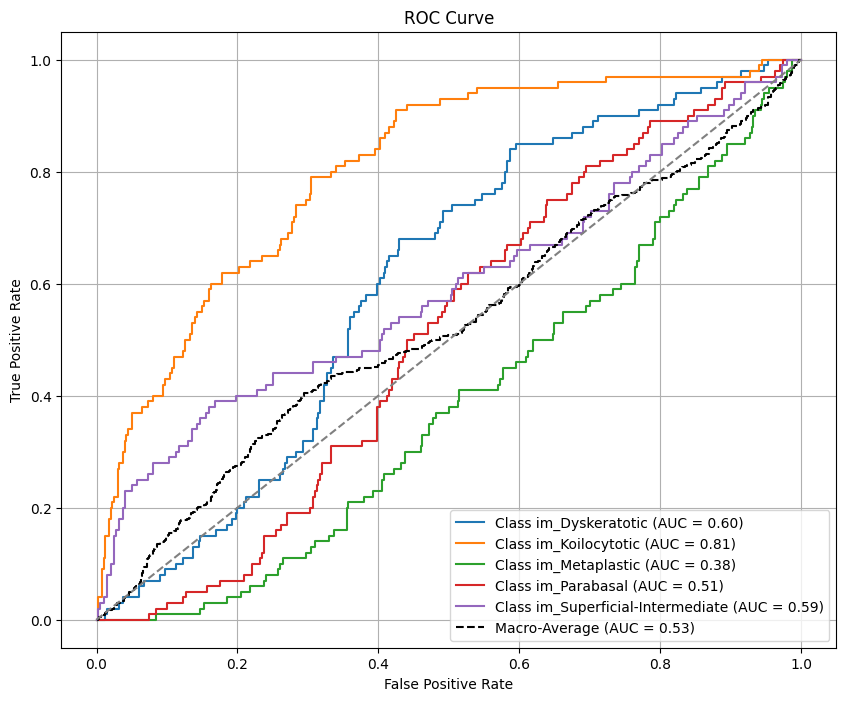

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Inception
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the Model
inchist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.5297 - loss: 20.4549 - val_accuracy: 0.7120 - val_loss: 15.4666
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 637ms/step - accuracy: 0.8607 - loss: 13.9069 - val_accuracy: 0.8380 - val_loss: 10.9447
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 610ms/step - accuracy: 0.9015 - loss: 9.9619 - val_accuracy: 0.8720 - val_loss: 7.8922
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 74s 632ms/step - accuracy: 0.9182 - loss: 7.1773 - val_accuracy: 0.8680 - val_loss: 5.7646
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 80s 610ms/step - accuracy: 0.9087 - loss: 5.2187 - val_accuracy: 0.9020 - val_loss: 4.2017
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 613ms/step - accuracy: 0.9219 - loss: 3.8531 - val_accuracy: 0.8360 - val_loss: 3.4559
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 619ms/step - accuracy: 0.9411 - loss: 2.8024 - val_accuracy: 0.8260 - val_loss: 2.6157
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 620ms/step - accuracy: 0.9317 - loss: 2.1207 - v

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9202 - loss: 1.1414
Test Accuracy: 88.99999856948853 %


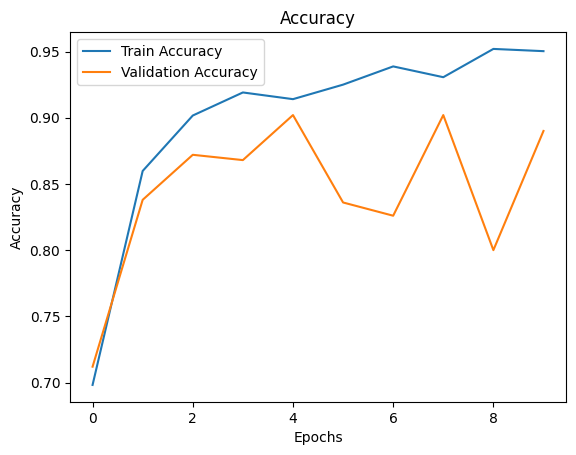

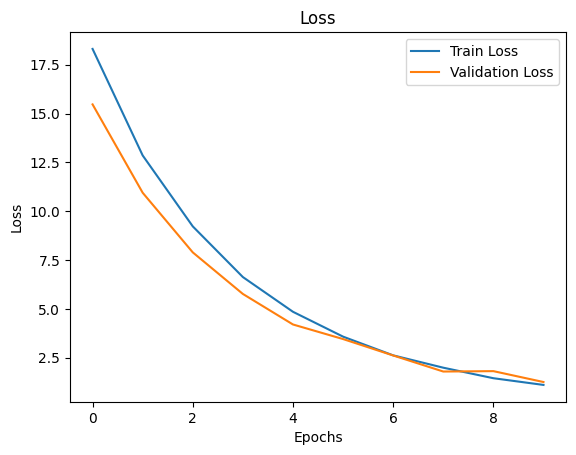

In [ ]:
# Plot accuracy
plt.plot(inchist.history['accuracy'], label='Train Accuracy')
plt.plot(inchist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(inchist.history['loss'], label='Train Loss')
plt.plot(inchist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 870ms/step


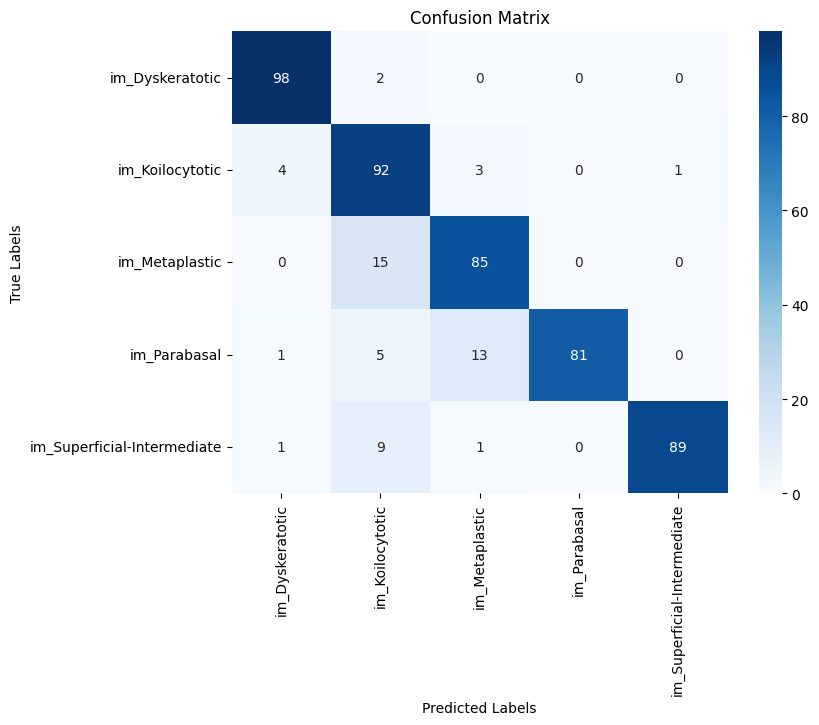

In [ ]:
# Confusion matrix
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.94      0.98      0.96       100
            im_Koilocytotic       0.75      0.92      0.83       100
             im_Metaplastic       0.83      0.85      0.84       100
               im_Parabasal       1.00      0.81      0.90       100
im_Superficial-Intermediate       0.99      0.89      0.94       100

                   accuracy                           0.89       500
                  macro avg       0.90      0.89      0.89       500
               weighted avg       0.90      0.89      0.89       500



In [ ]:
# Plot ROC Curve
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC: {:.4f}".format(roc_auc))

Macro-Averaged ROC-AUC: 0.9885


<ipython-input-13-96ad4249f651>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


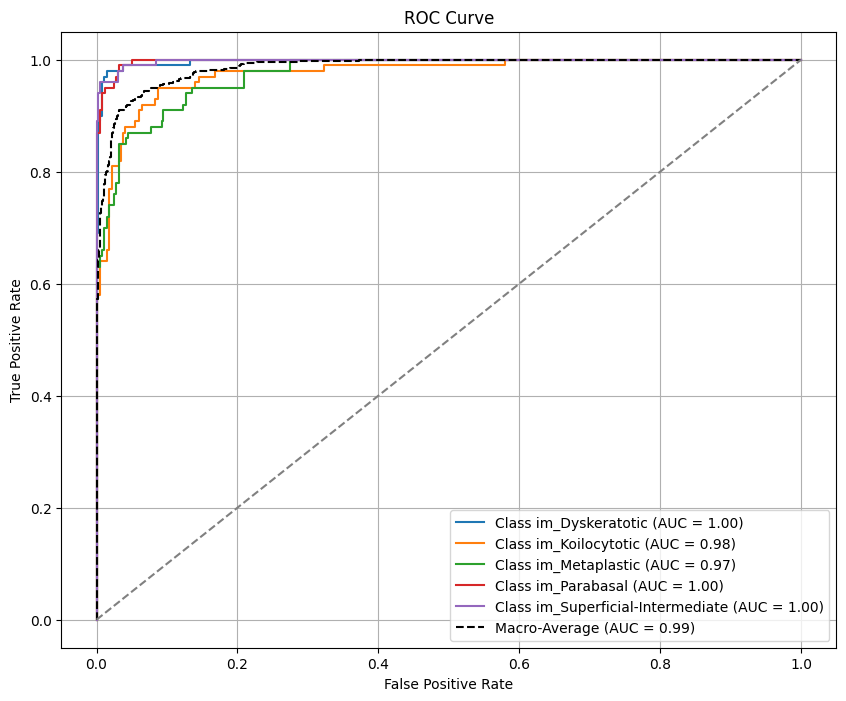

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# EfficientNet B0 version
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the Model
eff_hist_1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.5476 - loss: 11.9392 - val_accuracy: 0.2000 - val_loss: 10.6345
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 589ms/step - accuracy: 0.8808 - loss: 8.7945 - val_accuracy: 0.0900 - val_loss: 8.4810
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 602ms/step - accuracy: 0.9155 - loss: 6.6659 - val_accuracy: 0.2100 - val_loss: 7.1207
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 590ms/step - accuracy: 0.9313 - loss: 4.9670 - val_accuracy: 0.2380 - val_loss: 5.7101
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 579ms/step - accuracy: 0.9282 - loss: 3.7339 - val_accuracy: 0.2420 - val_loss: 5.7005
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 580ms/step - accuracy: 0.9407 - loss: 2.7645 - val_accuracy: 0.3200 - val_loss: 4.0809
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 609ms/step - accuracy: 0.9488 - loss: 2.0471 - val_accuracy: 0.6160 - val_loss: 2.5481
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 583ms/step - accuracy: 0.9570 - loss: 1

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc * 100, "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9452 - loss: 0.7620
Test Accuracy: 93.59999895095825 %


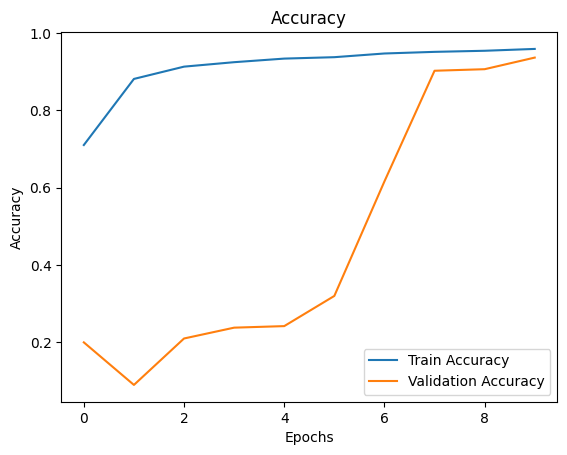

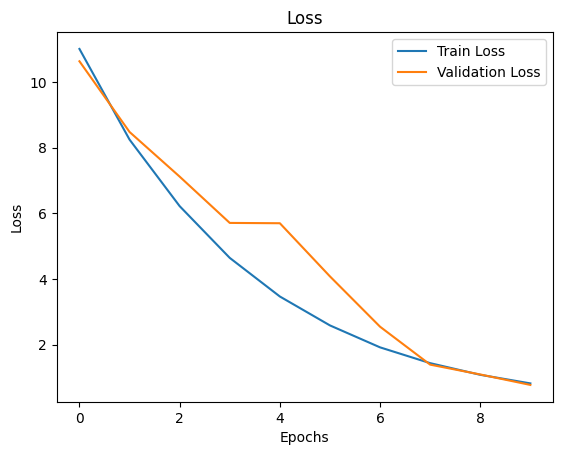

In [ ]:
# Plot accuracy
plt.plot(eff_hist_1.history['accuracy'], label='Train Accuracy')
plt.plot(eff_hist_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(eff_hist_1.history['loss'], label='Train Loss')
plt.plot(eff_hist_1.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 593ms/step


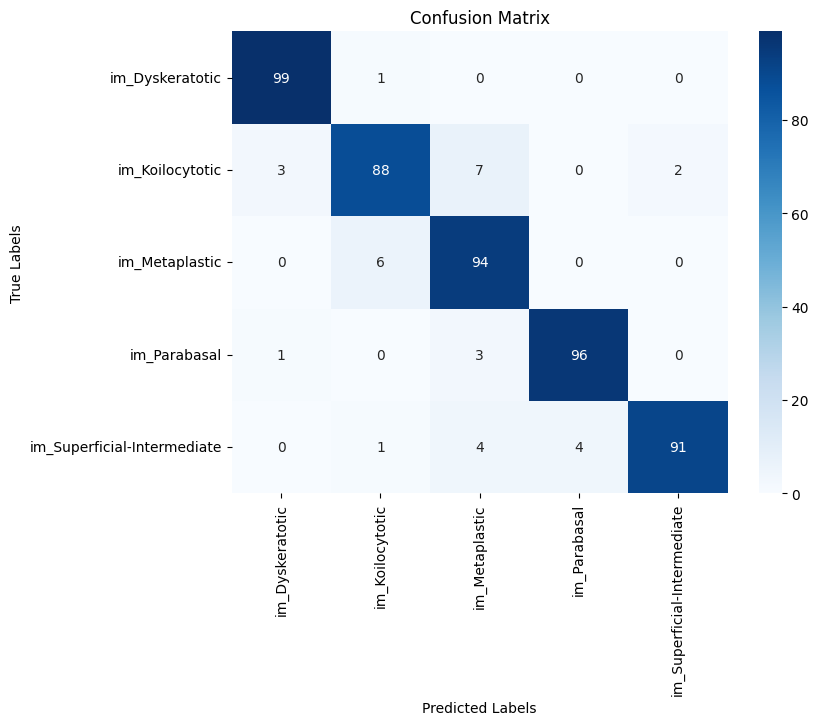

In [ ]:
# Confusion matrix
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.96      0.99      0.98       100
            im_Koilocytotic       0.92      0.88      0.90       100
             im_Metaplastic       0.87      0.94      0.90       100
               im_Parabasal       0.96      0.96      0.96       100
im_Superficial-Intermediate       0.98      0.91      0.94       100

                   accuracy                           0.94       500
                  macro avg       0.94      0.94      0.94       500
               weighted avg       0.94      0.94      0.94       500



In [ ]:
n_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# ROC-AUC score
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged ROC-AUC: {:.4f}".format(roc_auc))

Macro-Averaged ROC-AUC: 0.9962


<ipython-input-29-96ad4249f651>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


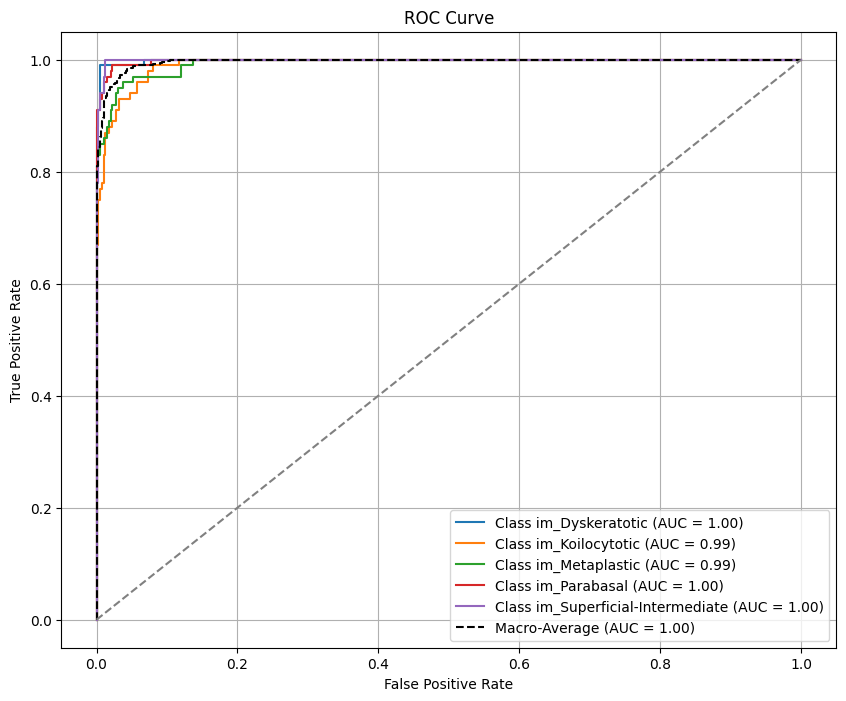

In [ ]:
# Plot ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Macro-Average (AUC = {roc_auc_micro:.2f})', color='black')

plt.plot([0, 1], [0, 1], 'k--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()